# Wind Data Objects

FLORIS v4 introduces WindData objects.  These include TimeSeries, WindRose, and WindTIRose.  These objects are used to hold inputs to FLORIS simulations, such as the ambient wind data, and to provide high-level methods for working with wind data.  This notebook provides an overview of the WindData objects and demonstrates how to use them.


## WindDataBase

WindDataBase is the base class for all WindData objects.  It provides a common interface for working with wind data.  The WindDataBase class is not intended to be used directly, but rather to be subclassed by more specific wind data objects. It is only important to mention that many of the methods in FLORIS that accept wind data as input will accept any WindDataBase object as input.  But is not typical to use it directly.

In [1]:
from floris.wind_data import WindDataBase
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.simplefilter("ignore")



## TimeSeries

TimeSeries objects are used to represent data which are in a time-series form, or more generally and data which is represented as a list of conditions without frequency weighting (i.e. not a wind rose).  In addition to representing time series input conditions, TimeSeries objects are useful for generating sweep inputs where most values are held constant while one input is swept through a range of values.  Also useful can be an input of identical repeated inputs which can be useful if some control setting is going to be swept.  TimeSeries represents data most similarly to how data structures within FLORIS are represented in that there are N wind_directions, wind_speeds etc., in the TimeSeries, the n_findex value in FLORIS will be N.

### TimeSeries Instantiation

In [2]:
from floris import TimeSeries

# Like FlorisModel, TimeSeries require wind directions, wind speeds, and turbulence intensities to be of the same length.
N = 50
wind_speeds = np.linspace(3, 15, N)
wind_directions = 270.0 * np.ones(N)
turbulence_intensities = 0.06 * np.ones(N)

# Create a TimeSeries object
time_series = TimeSeries(
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
)

### Broadcasting

Unlike FlorisModel, TimeSeries objects do allow broadcasting.  As long as one of the inputs is a numpy array, the other inputs can be specified as a float, which will be broadcasted to the length of the numpy array.


In [3]:
# Equivalent to the above
time_series = TimeSeries(
    wind_directions=270.0, wind_speeds=wind_speeds, turbulence_intensities=0.06
)

### Value

In addition to wind directions, wind speeds, and turbulence intensities, TimeSeries objects can also hold an array of values.  These values can be used for example to represent electricity market prices (e.g., price/MWh). The values are intended to be multiplied by the corresponding wind plant power at each time step or wind condition to determine the total value produced over all conditions.    

If values are included in the TimeSeries object, they must be the same length as the wind directions, wind speeds, and turbulence intensities.  If included, values enable calculation of Annual Value Production (AVP), in addition to AEP, and certain optimization routines, such as layout, can be configured to maximize value instead of energy production.

In [4]:
# Including value for each indices
time_series = TimeSeries(
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
    values=np.linspace(0, 1, N),
)

### Generating Turbulence Intensity

The TimeSeries object also includes functions for generating TI as a function of wind direction and wind speed.  This can be accomplished by passing in a custom function, or by taking use of the IEC 61400-1 standard 

Text(0, 0.5, 'Turbulence Intensity')

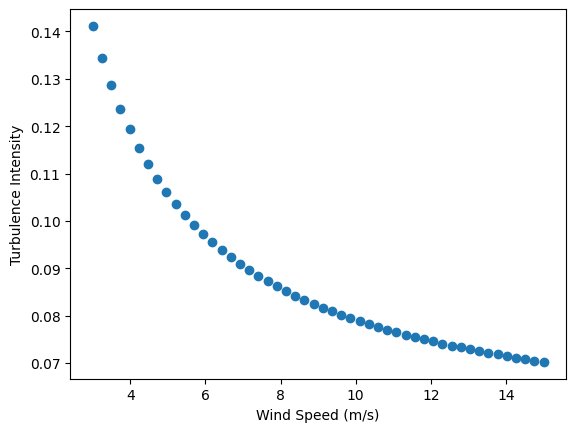

In [5]:
# Assign TI as a function of wind speed using the IEC method and default parameters.
time_series.assign_ti_using_IEC_method()

fig, ax = plt.subplots()
ax.scatter(time_series.wind_speeds, time_series.turbulence_intensities)
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Turbulence Intensity")

### Generating Value

The TimeSeries object also includes functions for generating value as a function of wind direction and wind speed. This can be accomplished by passing in a custom function using the `TimeSeries.assign_value_using_wd_ws_function` method, or by using the `TimeSeries.assign_value_piecewise_linear` method, which approximates value using a two-segment piecewise linear function of wind speed. When using the default parameters, this produces a value vs. wind speed that approximates the normalized mean electricity price vs. wind speed curve for the SPP market in the U.S. for years 2018-2020 from figure 7 in "The value of wake steering wind farm flow control in US energy markets," Wind Energy Science, 2024. https://doi.org/10.5194/wes-9-219-2024. 

Text(0, 0.5, 'Value (normalized price/MWh)')

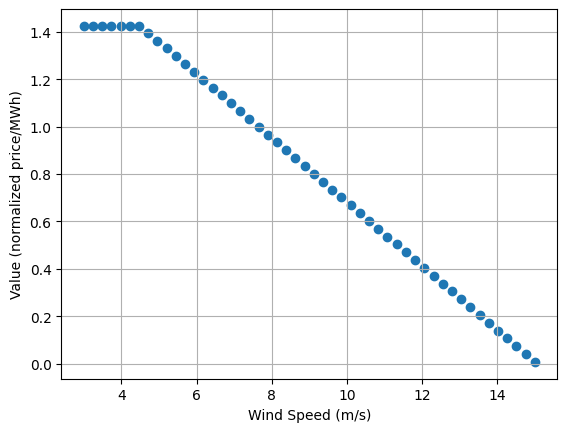

In [6]:
# Assign value as a function of wind speed using the piecewise linear method and default parameters.
time_series.assign_value_piecewise_linear()

fig, ax = plt.subplots()
ax.scatter(time_series.wind_speeds, time_series.values)
ax.grid()
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Value (normalized price/MWh)")

## WindRose

A second wind data object is the WindRose, which represents the data as:

 - An array of wind directions
 - An array of wind speeds
 - A table of turbulence intensities of size (n_wind_directions, n_wind_speeds) which represents the TI at each wind direction and wind speed.
 - A table of frequencies of size (n_wind_directions, n_wind_speeds) which represents the frequency of occurance of each wind direction and wind speed.
 - An (optional) table of values of size (n_wind_directions, n_wind_speeds) which represents the value of the wind condition.

In [7]:
from floris import WindRose

wind_directions = np.array([270, 280])  # 2 Wind Directions
wind_speeds = np.array([6.0, 7.0, 8.0])  # 3 Wind Speeds

# Create a WindRose object, not indicating a frequency table indicates uniform frequency
wind_rose = WindRose(
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    ti_table=0.06,  # As in Time Series, a float indicates a constant table
)

wind_rose.freq_table

array([[0.16666667, 0.16666667, 0.16666667],
       [0.16666667, 0.16666667, 0.16666667]])

In [8]:
# Several of the functions implemented for TimeSeries are likewise implemented for WindRose

wind_rose.assign_ti_using_IEC_method()

print("wind_rose.ti_table")
print(wind_rose.ti_table)

wind_rose.assign_value_piecewise_linear()

print("\nwind_rose.value_table")
print(wind_rose.value_table)

wind_rose.ti_table
[[0.09683333 0.0905     0.08575   ]
 [0.09683333 0.0905     0.08575   ]]

wind_rose.value_table
[[1.2225 1.0875 0.9525]
 [1.2225 1.0875 0.9525]]


## WindTIRose

The WindTIRose is similar to the WindRose except that rather than specififying wind directions and wind speeds as arrays, with TI, frequency, adn value as 2D tables, the WindTIRose specificies wind directions, wind speeds, and turbulence intensities as arrays with the frequency and value tables now 3 dimensional, representing the frequency and value of each wind direction, wind speed, and turbulence intensity occurence.

In [9]:
from floris import WindTIRose

wind_directions = np.array([270, 280])  # 2 Wind Directions
wind_speeds = np.array([6.0, 7.0, 8.0])  # 3 Wind Speeds
turbulence_intensities = np.array([0.06, 0.07, 0.08])  # 3 Turbulence Intensities

# The frequency table therefore is 2 x 3 x 3 and the sum over all entries = 1
freq_table = np.array(
    [
        [[2 / 18, 0, 1 / 18], [1 / 18, 1 / 18, 1 / 18], [1 / 18, 1 / 18, 1 / 18]],
        [[1 / 18, 1 / 18, 1 / 18], [1 / 18, 1 / 18, 1 / 18], [1 / 18, 1 / 18, 1 / 18]],
    ]
)

# The value table has the same dimensions as frequency
value_table = np.ones_like(freq_table)

wind_ti_rose = WindTIRose(
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
    freq_table=freq_table,
    value_table=value_table,
)

# Demonstrate setting value again
wind_ti_rose.assign_value_piecewise_linear()

## Conversions

Several methods for converting between WindData objects and resampling to different bin sizes are provided

In [10]:
# Converting from TimeSeries to WindRose/WindTiRose by binning
wind_rose = time_series.to_WindRose(wd_step=2, ws_step=1)
wind_ti_rose = time_series.to_WindTIRose(wd_step=2, ws_step=1, ti_step=0.01)

### Aggregating and Resampling WindRose

<PolarAxes: >

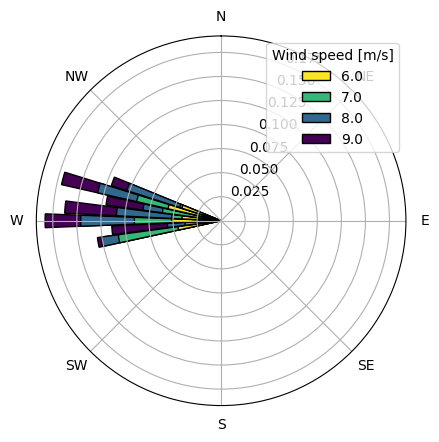

In [11]:
# Generate a wind rose with a few wind directions and speeds
wind_directions = np.array([260, 265, 270, 275, 280, 285, 290])
wind_speeds = np.array([6.0, 7.0, 8.0, 9.0])
freq_table = np.random.rand(7, 4)
freq_table /= freq_table.sum()

wind_rose = WindRose(
    wind_directions=wind_directions, wind_speeds=wind_speeds, ti_table=0.06, freq_table=freq_table
)

wind_rose.plot()

<PolarAxes: >

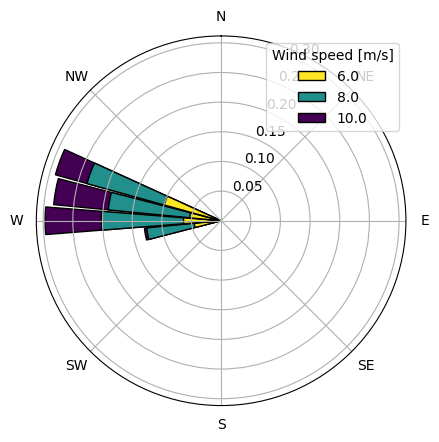

In [12]:
# The downsample functions of  WindRose/WindTiRose allows for
# aggregating the data into larger bin sizes
wind_rose_aggregated = wind_rose.downsample(wd_step=10, ws_step=2)
wind_rose_aggregated.plot()

<PolarAxes: >

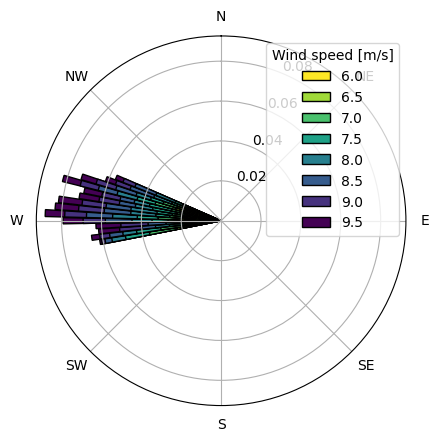

In [13]:
# For upsampling, the upsample method is available which can
# interpolate the data via linear or nearest-neighbor interpolation
wind_rose_resampled = wind_rose.upsample(wd_step=2.5, ws_step=0.5)
wind_rose_resampled.plot()

## Plotting

There are several plotting methods available to help visualize wind data objects

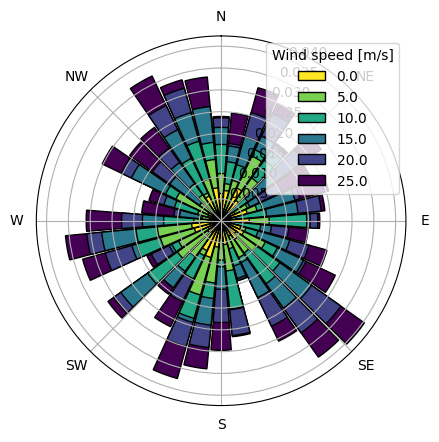

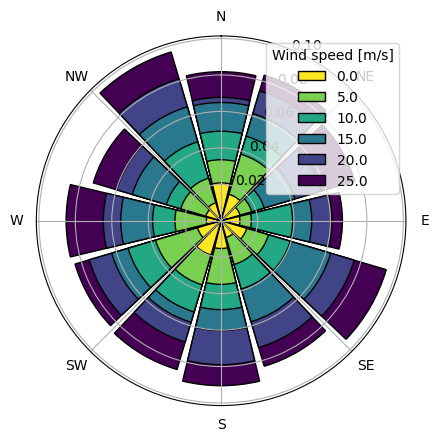

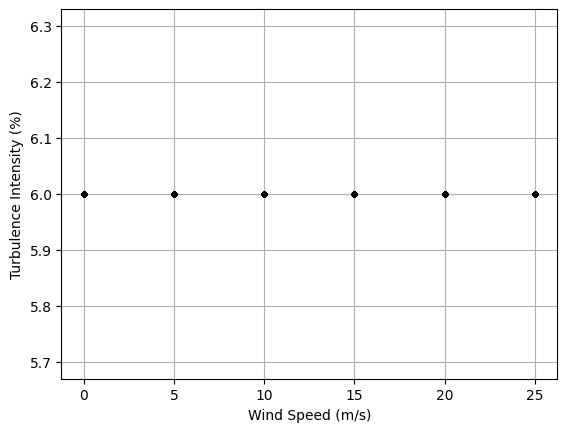

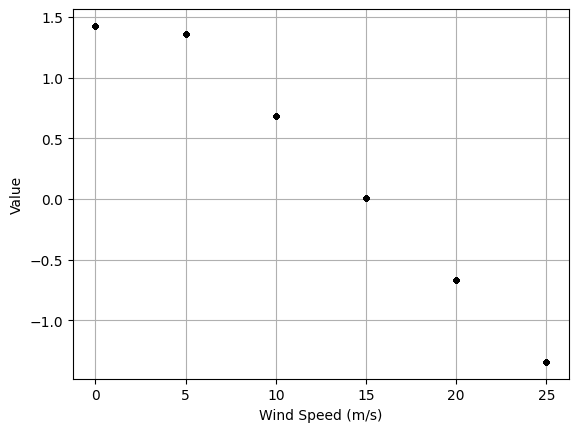

In [14]:
wind_directions = np.arange(0, 360, 10)
wind_speeds = np.arange(0.0, 30.0, 5.0)
freq_table = np.random.rand(36, 6)
freq_table = freq_table / freq_table.sum()

wind_rose = WindRose(
    wind_directions=wind_directions, wind_speeds=wind_speeds, ti_table=0.06, freq_table=freq_table
)

# Set value
wind_rose.assign_value_piecewise_linear()

wind_rose.plot()

# Plot with aggregated wind directions
wind_rose.plot(wd_step=30)

wind_rose.plot_ti_over_ws()

wind_rose.plot_value_over_ws()

## Setting FLORIS

WindData objects are used to set wind direction, speed, TI, frequency, and value in a FlorisModel (or UncertainFlorisModel).

### TimeSeries

In [15]:
# TimeSeries

from floris import FlorisModel

# Create a FlorisModel object
fmodel = FlorisModel("../examples/inputs/gch.yaml")

# Set a two-turbine layout
fmodel.set(layout_x=[0, 500], layout_y=[0, 0])

# Make a set of inputs with 5 wind directions, while wind speed and TI are constant
wind_directions = np.array([270, 280, 290, 300, 310])
wind_speeds = 8.0 * np.ones(5)
turbulence_intensities = 0.06 * np.ones(5)

fmodel.set(
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
)

# Is equivalent to the following (but now we'll include value as well):
time_series = TimeSeries(
    wind_directions=wind_directions, wind_speeds=8.0, turbulence_intensities=0.06
)

# Scale some of the default parameters to get reasonable values representing USD/MWh
time_series.assign_value_piecewise_linear(value_zero_ws=25 * 1.425, slope_2=-25 * 0.135)

fmodel.set(wind_data=time_series)

In [16]:
# Run the model and get outputs
fmodel.run()

# Get the power outputs
turbine_powers = fmodel.get_turbine_powers()
farm_power = fmodel.get_farm_power()
expected_farm_power = fmodel.get_expected_farm_power()
aep = fmodel.get_farm_AEP()

# Get value outputs
expected_farm_value = fmodel.get_expected_farm_value()
avp = fmodel.get_farm_AVP()

# Display
print(f"Turbine power have shape {turbine_powers.shape} and are {turbine_powers}")
print(f"Farm power has shape {farm_power.shape} and is {farm_power}")
print(f"Expected farm power has shape {expected_farm_power.shape} and is {expected_farm_power}")
print(f"Farm AEP is {aep/1e9} GWh")
print(f"Expected farm value has shape {expected_farm_power.shape} and is {expected_farm_value}")
print(f"Farm annual value production (AVP) is {avp/1e6} USD")

floris.floris_model.FlorisModel WARNING Computing AEP with uniform frequencies. Results results may not reflect annual operation.
floris.floris_model.FlorisModel WARNING Computing AVP with uniform frequencies. Results results may not reflect annual operation.


Turbine power have shape (5, 2) and are [[1753954.45917917  354990.76412771]
 [1753954.45917917 1320346.28513924]
 [1753954.45917917 1748551.48278202]
 [1753954.45917917 1753951.95262087]
 [1753954.45917917 1753954.45908051]]
Farm power has shape (5,) and is [2108945.22330688 3074300.74431841 3502505.94196119 3507906.41180004
 3507908.91825968]
Expected farm power has shape () and is 3140313.447929242
Farm AEP is 27.50914580386016 GWh
Expected farm value has shape () and is 74778713.9788151
Farm annual value production (AVP) is 655061.5344544202 USD


### WindRose

WindRose objects set FLORIS as TimeSeries, but there are some additional considerations.

  - By default, wind direction/speed combinations with 0 frequency are not run
  - The outputs of the functions get_turbine_powers and get_farm_power will be reshaped to have dimensions num_wind_directions x num_wind_speeds ( x num_turbines)

In [17]:
wind_directions = np.array([270, 280])  # 2 Wind Directions
wind_speeds = np.array([6.0, 7.0, 8.0])  # 3 Wind Speeds

# Frequency matrix is 2 x 3, include some 0 frequency results
freq_table = np.array([[0, 0, 1 / 2], [1 / 6, 1 / 6, 1 / 6]])

# Create a WindRose object, not indicating a frequency table indicates uniform frequency
wind_rose = WindRose(
    wind_directions=wind_directions, wind_speeds=wind_speeds, ti_table=0.06, freq_table=freq_table
)

# Set value and scale some of the default parameters to get reasonable values representing USD/MWh
wind_rose.assign_value_piecewise_linear(value_zero_ws=25 * 1.425, slope_2=-25 * 0.135)

fmodel.set(wind_data=wind_rose)

print(f"Fmodel has n_findex {fmodel.core.flow_field.n_findex} because two cases have 0 frequency")

Fmodel has n_findex 4 because two cases have 0 frequency


In [18]:
# Run the model and collect the outputs
fmodel.run()

# Get the power outputs
turbine_powers = fmodel.get_turbine_powers()
farm_power = fmodel.get_farm_power()
expected_farm_power = fmodel.get_expected_farm_power()
aep = fmodel.get_farm_AEP()

# Get value outputs
expected_farm_value = fmodel.get_expected_farm_value()
avp = fmodel.get_farm_AVP()

# Note that the nan values in the non-computed cases are expected since these are not run

# Display
print(f"Turbine power have shape {turbine_powers.shape} and are {turbine_powers}")
print(f"Farm power has shape {farm_power.shape} and is {farm_power}")
print(f"Expected farm power has shape {expected_farm_power.shape} and is {expected_farm_power}")
print(f"Farm AEP is {aep/1e9} GWh")
print(f"Expected farm value has shape {expected_farm_power.shape} and is {expected_farm_value}")
print(f"Farm annual value production (AVP) is {avp/1e6} USD")

Turbine power have shape (2, 3, 2) and are [[[             nan              nan]
  [             nan              nan]
  [1753954.45917917  354990.76412771]]

 [[ 731003.41073165  523849.55426108]
  [1176825.66812027  876937.12082426]
  [1753954.45917917 1320346.28513924]]]
Farm power has shape (2, 3) and is [[             nan              nan 2108945.22330688]
 [1254852.96499273 2053762.78894454 3074300.74431841]]
Expected farm power has shape () and is 2118292.0280293887
Farm AEP is 18.556238165537444 GWh
Expected farm value has shape () and is 53008780.071847945
Farm annual value production (AVP) is 464356.913429388 USD


In [19]:
# It's possible however to force the running of 0 frequency cases
wind_rose = WindRose(
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    ti_table=0.06,
    freq_table=freq_table,
    compute_zero_freq_occurrence=True,
)

# Set value and scale some of the default parameters to get reasonable values representing USD/MWh
wind_rose.assign_value_piecewise_linear(value_zero_ws=25 * 1.425, slope_2=-25 * 0.135)

fmodel.set(wind_data=wind_rose)

print(f"Fmodel has n_findex {fmodel.core.flow_field.n_findex}")

# Run the model and collect the outputs
fmodel.run()

# Get the power outputs
turbine_powers = fmodel.get_turbine_powers()
farm_power = fmodel.get_farm_power()
expected_farm_power = fmodel.get_expected_farm_power()
aep = fmodel.get_farm_AEP()

# Get value outputs
expected_farm_value = fmodel.get_expected_farm_value()
avp = fmodel.get_farm_AVP()

# Display
print("Turbine powers and farm power are now computed for all cases")
print(f"Turbine power have shape {turbine_powers.shape} and are {turbine_powers}")
print(f"Farm power has shape {farm_power.shape} and is {farm_power}")

print(
    "Expected farm power and value, AEP, and AVP are the same as before since the new cases are weighted by 0"
)
print(f"Expected farm power has shape {expected_farm_power.shape} and is {expected_farm_power}")
print(f"Farm AEP is {aep/1e9} GWh")
print(f"Expected farm value has shape {expected_farm_power.shape} and is {expected_farm_value}")
print(f"Farm annual value production (AVP) is {avp/1e6} USD")

Fmodel has n_findex 6
Turbine powers and farm power are now computed for all cases
Turbine power have shape (2, 3, 2) and are [[[ 731003.41073165   80999.08780495]
  [1176825.66812027  191637.98384374]
  [1753954.45917917  354990.76412771]]

 [[ 731003.41073165  523849.55426108]
  [1176825.66812027  876937.12082426]
  [1753954.45917917 1320346.28513924]]]
Farm power has shape (2, 3) and is [[ 812002.4985366  1368463.65196401 2108945.22330688]
 [1254852.96499273 2053762.78894454 3074300.74431841]]
Expected farm power and value, AEP, and AVP are the same as before since the new cases are weighted by 0
Expected farm power has shape () and is 2118292.0280293887
Farm AEP is 18.556238165537444 GWh
Expected farm value has shape () and is 53008780.071847945
Farm annual value production (AVP) is 464356.913429388 USD


# WindRoseWRG

The `WindRoseWRG` is a data object which is used to represent within FLORIS the information in a Wind Resource Grid (WRG) file.  `WindRoseWRG` is a type of WindData object, like `WindRose` and `TimeSeries`, that
is used to store wind data in a format that can be used by the FLORIS model.  `WindRoseWRG` is different that `WindRose` however because the internal data holds the information of the WRG file and then a `WindRose` object is created 
for each turbine in a provided layout.

In [20]:
from floris import WindRoseWRG

In [21]:
# Read a WRG file (from examples)
wind_rose_wrg = WindRoseWRG("../examples/examples_wind_resource_grid/wrg_example.wrg")

In [22]:
# Print some basic information
print(wind_rose_wrg)

WindResourceGrid with 2 x 3 grid points, min x: 0.0, min y: 0.0, grid size: 1000.0, z: 0.0, h: 90.0, 12 sectors
Wind directions in file: [  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300. 330.]
Wind directions: [  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300. 330.]
Wind speeds: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25.]
ti_table: 0.06


In [23]:
# Aggregate the wind speeds and directions
wind_rose_wrg.set_wd_step(5.0)
wind_rose_wrg.set_wind_speeds(np.arange(0, 30, 5))

In [24]:
# Set a turbine layout within the grid points of the WRG file
layout_x = np.array([0, 500, 1000])
layout_y = np.array([0, 1000, 2000])

In [25]:
# Set up a FLORIS model with the above layout and wind_rose_wrg
fmodel = FlorisModel("../examples/inputs/gch.yaml")

fmodel.set(layout_x=layout_x, layout_y=layout_y, wind_data=wind_rose_wrg)

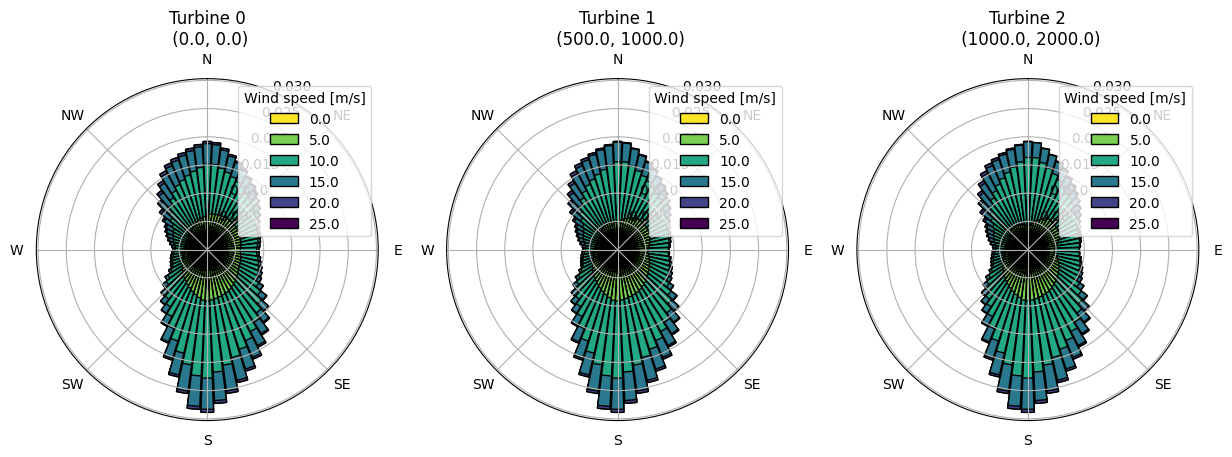

In [26]:
# Within FlorisModel, the is set to a separate wind rose per turbine
fig, axarr = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(polar=True))
fmodel.wind_data.plot_wind_roses(axarr=axarr)

In [27]:
# Can get the expected power for each turbine
fmodel.run()
print(fmodel.get_expected_turbine_powers())

[2296892.47124259 2297743.68483228 2342752.51651458]


In [28]:
# Getting expected farm power and AEP weights each turbine by its own wind rose
print(fmodel.get_expected_farm_power())
print(fmodel.get_farm_AEP())

6937388.672589453
60771524771.883606


Using point 0 at (0.0, 0.0) as reference location


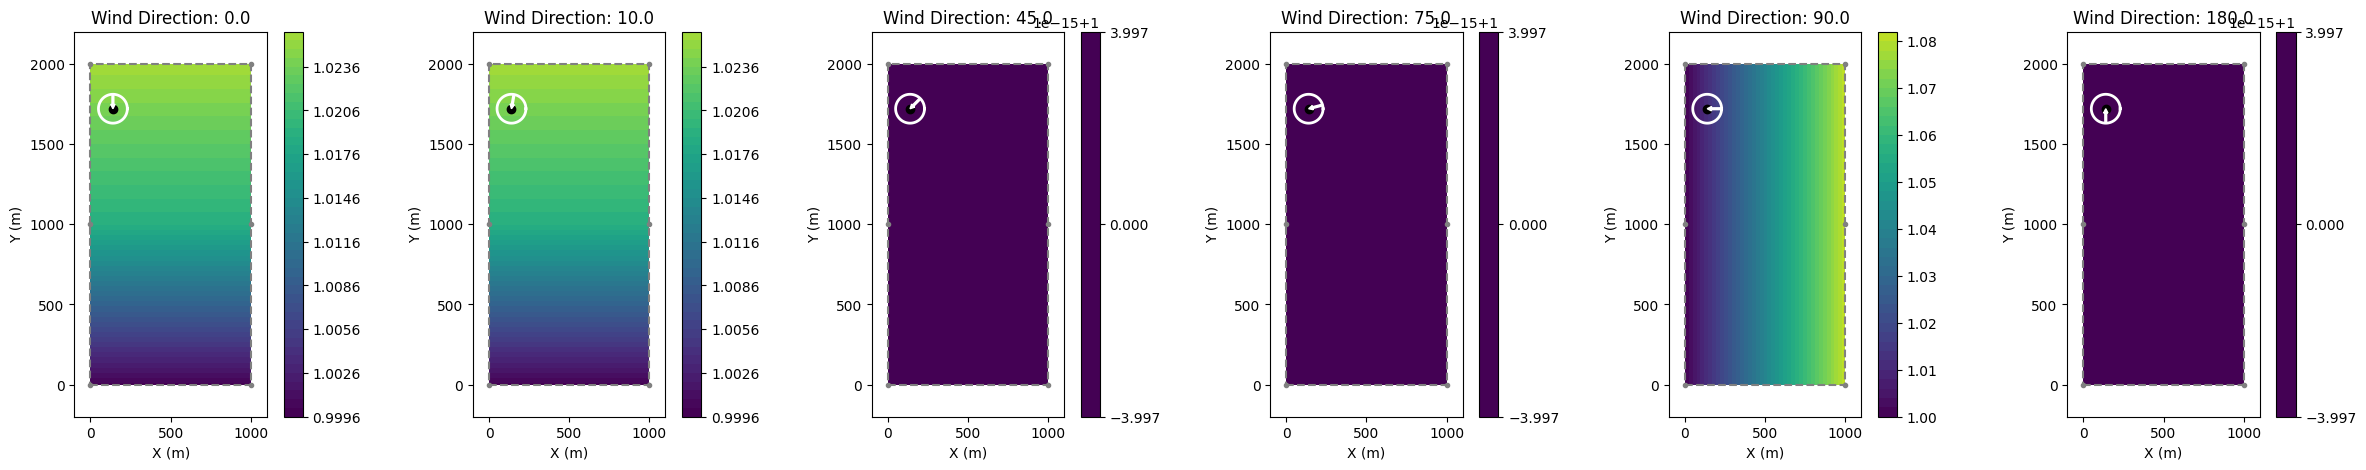

In [29]:
# Use the get_heterogeneous_map method to generate a WindRose that represents
# the information in the WindRoseWRG, rather than a set of WindRose objects
# but as a  single WindRose object (for one location) and a HeterogeneousMap
# the describes the speed up information per direction across the domain
# This will allow running the optimization for a single wind speed while still
# accounting for the difference in wind speeds in location by direction
wind_rose_het = wind_rose_wrg.get_heterogeneous_wind_rose(
    fmodel=fmodel,
    x_loc=0.0,
    y_loc=0.0,
    representative_wind_speed=10.0,
)

# Pull out the heterogeneous plot to show the underlying speedups
het_map = wind_rose_het.heterogeneous_map
wind_direction_to_plot = [0.0, 10.0, 45.0, 75.0, 90.0, 180.0]

# Show the het_map for a few wind directions
fig, axarr = plt.subplots(1, len(wind_direction_to_plot), figsize=(30, 5))
axarr = axarr.flatten()
for i, wd in enumerate(wind_direction_to_plot):
    het_map.plot_single_speed_multiplier(
        wind_direction=wd,
        wind_speed=8.0,
        ax=axarr[i],
        show_colorbar=True,
    )

    axarr[i].set_title(f"Wind Direction: {wd}")